In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import os
# import glob
import seaborn as sns

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
# Data dir
data_dir = r'/home/disk/sipn/nicway/data/model/nmme/test'
cfile = 'sic_OImon_GFDL-FLORB01_FLORB01-P1-ECDA-v3.1-062014_r9i1p1_201406-201505.nc'
file_in = os.path.join(data_dir, cfile)

In [4]:
# Open Data
ds = xr.open_dataset(file_in)

In [5]:
# Average over all sea ice categories 
sic = ds.sic.sum(dim='ct', skipna=False)

In [6]:
# Get info about target grid
flat = r'/home/disk/eos11/bitz/observations/seaice/data/psn25lats_v3.dat'
flon = r'/home/disk/eos11/bitz/observations/seaice/data/psn25lons_v3.dat'
NY=304; 
NX=448;

def readBinFile(f, nx, ny):
    with open(f, 'rb') as fid:
        data_array = np.fromfile(f, np.int32)*1e-5
    return data_array.reshape((nx,ny))

In [7]:
lat = readBinFile(flat, NX, NY).T
lon = readBinFile(flon, NX, NY).T
ds_out = xr.Dataset({'lat': (['y', 'x'],  lat), 'lon': (['y', 'x'], lon)})
ds_out

<xarray.Dataset>
Dimensions:  (x: 448, y: 304)
Dimensions without coordinates: x, y
Data variables:
    lat      (y, x) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
    lon      (y, x) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...

In [8]:
# Plot target lat and lon
# ds_out.lon.plot.pcolormesh()

In [9]:
# ds_out.lat.plot.pcolormesh()

In [16]:
# Calculate regridding matrix
regridder = xe.Regridder(sic, ds_out, 'bilinear', periodic=True)
# Regrid
sic_out = regridder(sic)
# sic_out

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Create weight file: bilinear_200x360_304x448_peri.nc


In [11]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'lightgrey')

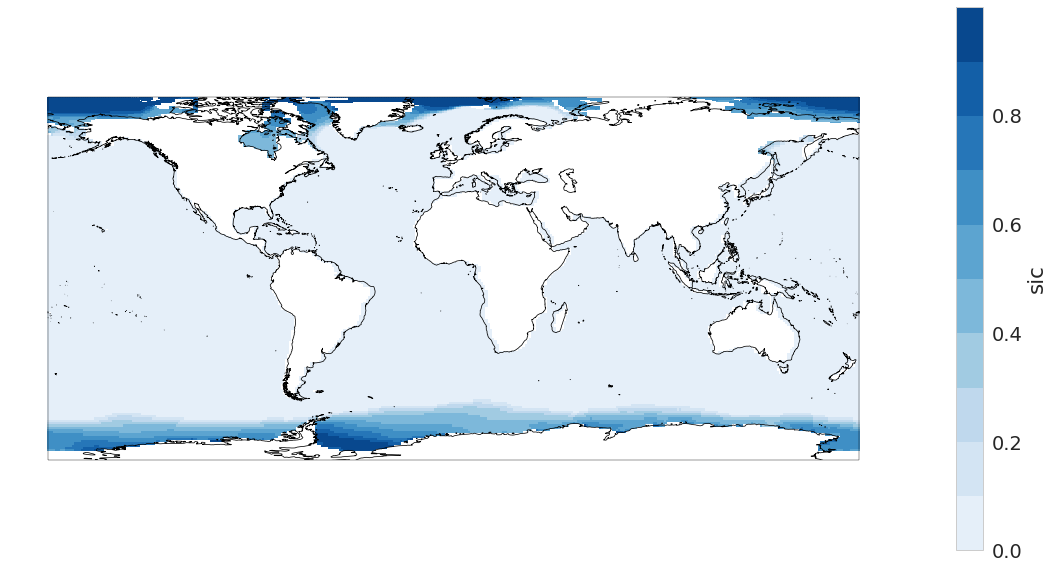

In [17]:
# Plot original projection
plt.figure(figsize=(20,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
sic.mean(dim='time').plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                 vmin=sic.min().values, vmax=sic.max().values,
                                 cmap=matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10)));
ax1.coastlines(linewidth=0.75, color='black', resolution='50m');

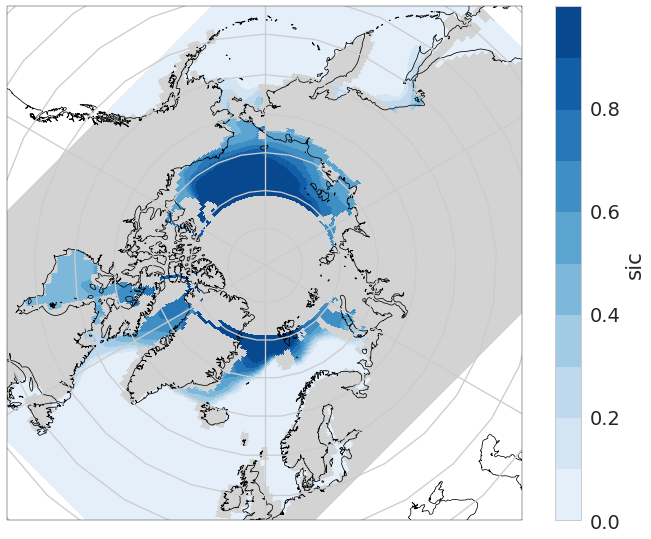

In [18]:
# Plot SIC on target projection
plt.figure(figsize=(10,8));
ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
sic_out.mean(dim='time').plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
# Add coastlines and meridians/parallels 
ax1.coastlines(linewidth=0.75, color='black', resolution='50m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
plt.tight_layout()

In [14]:
# Save new file
f_out = os.path.join(data_dir, os.path.splitext(cfile)[0]+'_Stereo.nc')
sic_out.to_netcdf(f_out)

In [15]:
# Clean up
regridder.clean_weight_file()  # clean-up

Remove file bilinear_200x360_304x448_peri.nc
